In [30]:
#%pip install geoai-py
import geoai  # For geospatial AI functionalities
import leafmap  # For interactive mapping
import torch  


# For downloading NAIP (National Agriculture Imagery Program) imagery,  building footprints from Overture Maps
from geoai.download import (
    download_naip,  
    download_overture_buildings, 
    extract_building_stats,  
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (geoai.__version__)
print (leafmap.__version__)
print (device)


0.6.0
0.46.7
cuda


In [31]:
#Download sample data
train_raster_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip/naip_water_train.tif"
train_masks_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip/naip_water_masks.tif"
test_raster_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip/naip_water_test.tif"

In [32]:
train_raster_path = geoai.download_file(train_raster_url)
train_masks_path = geoai.download_file(train_masks_url)
test_raster_path = geoai.download_file(test_raster_url)

File already exists: naip_water_train.tif
File already exists: naip_water_masks.tif
File already exists: naip_water_test.tif


In [33]:
geoai.print_raster_info(train_raster_path, show_preview=False )

===== RASTER INFORMATION: naip_water_train.tif =====
Driver: GTiff
Dimensions: 5390 x 7580 pixels
Number of bands: 4
Data type: uint8
Coordinate Reference System: EPSG:26914
Georeferenced Bounds: BoundingBox(left=485430.0, bottom=5204860.0, right=490820.0, top=5212440.0)
Pixel Resolution: 1.0, 1.0
NoData Value: None

----- Band Statistics -----
Band 1:
  Min: 36.00
  Max: 238.00
  Mean: 127.01
  Std Dev: 34.38
Band 2:
  Min: 46.00
  Max: 233.00
  Mean: 121.56
  Std Dev: 22.03
Band 3:
  Min: 57.00
  Max: 237.00
  Mean: 105.59
  Std Dev: 18.37
Band 4:
  Min: 19.00
  Max: 238.00
  Mean: 135.77
  Std Dev: 36.26


In [34]:
#Visualize sample data
geoai.view_raster(train_masks_url, nodata=0, basemap=train_raster_url)

In [35]:
out_folder = "output"

In [36]:
#Create training data
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_masks_path,
    tile_size=512,
    stride=128,
    buffer_radius=0,
)

Detected in_class_data as raster: naip_water_masks.tif
Raster CRS: EPSG:26914
Raster dimensions: 5420 x 7602

Raster info for naip_water_train.tif:
  CRS: EPSG:26914
  Dimensions: 5390 x 7580
  Resolution: (1.0, 1.0)
  Bands: 4
  Bounds: BoundingBox(left=485430.0, bottom=5204860.0, right=490820.0, top=5212440.0)
Found 1 unique classes in raster: [1]


Generated: 2280, With features: 2170: 100%|██████████| 2280/2280 [02:26<00:00, 15.60it/s]


------- Export Summary -------
Total tiles exported: 2280
Tiles with features: 2170 (95.2%)
Average feature pixels per tile: 101525.1
Output saved to: output

------- Georeference Verification -------


In [12]:
#Training object detection model
geoai.train_MaskRCNN_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models",
    num_channels=4,
    pretrained=True,
    batch_size=4,
    num_epochs=3,
    learning_rate=0.001,
    val_split=0.4,
)
masks_path = "naip_water_prediction.tif"
model_path = f"{out_folder}/models/best_model.pth"

Using device: cuda
Found 2280 image files and 2280 label files
Training on 1368 images, validating on 912 images
Epoch: 0, Batch: 0/342, Loss: 8.4128, Time: 48.30s
Epoch: 0, Batch: 10/342, Loss: 1.8895, Time: 93.59s
Epoch: 0, Batch: 20/342, Loss: 0.8298, Time: 86.61s
Epoch: 0, Batch: 30/342, Loss: 1.0188, Time: 80.73s
Epoch: 0, Batch: 40/342, Loss: 1.0681, Time: 96.40s
Epoch: 0, Batch: 50/342, Loss: 1.0241, Time: 99.94s
Epoch: 0, Batch: 60/342, Loss: 0.9550, Time: 100.60s
Epoch: 0, Batch: 70/342, Loss: 1.3558, Time: 102.95s
Epoch: 0, Batch: 80/342, Loss: 0.5954, Time: 89.97s
Epoch: 0, Batch: 90/342, Loss: 0.7015, Time: 97.64s
Epoch: 0, Batch: 100/342, Loss: 0.6068, Time: 101.30s
Epoch: 0, Batch: 110/342, Loss: 0.2939, Time: 95.02s
Epoch: 0, Batch: 120/342, Loss: 0.3653, Time: 100.09s
Epoch: 0, Batch: 130/342, Loss: 0.7774, Time: 104.35s
Epoch: 0, Batch: 140/342, Loss: 0.5277, Time: 112.02s
Epoch: 0, Batch: 150/342, Loss: 0.9903, Time: 99.25s
Epoch: 0, Batch: 160/342, Loss: 1.0727, Time

In [13]:
#Run inference
geoai.object_detection(
    test_raster_path,
    masks_path,
    model_path,
    window_size=512,
    overlap=128,
    confidence_threshold=0.3,
    batch_size=4,
    num_channels=4,
)

Processing 280 windows with size 512x512 and overlap 128...


315it [02:32,  2.06it/s]                         


Inference completed in 153.00 seconds
Saved prediction to naip_water_prediction.tif


In [14]:
output_path = "naip_water_prediction.geojson"
#Vectorize masks
gdf = geoai.raster_to_vector(
    masks_path, output_path, min_area=1000, simplify_tolerance=1
)

Vectorized data saved to naip_water_prediction.geojson


In [15]:
gdf = geoai.add_geometric_properties(gdf)

In [16]:
len(gdf)

80

In [24]:
geoai.view_vector_interactive(gdf, tiles=test_raster_url)

<Axes: >

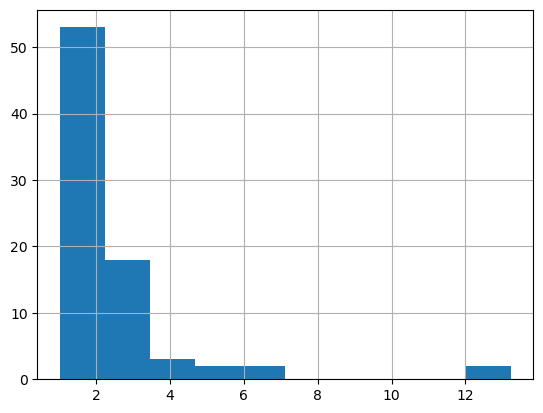

In [18]:
gdf["elongation"].hist()

In [19]:
gdf_filtered = gdf[gdf["elongation"] < 10]

In [20]:
len(gdf_filtered)

78

In [28]:
#Visualize results
#geoai.view_vector_interactive(gdf_filtered, tiles=test_raster_url)

In [29]:
geoai.create_split_map(
    left_layer=gdf_filtered,
    right_layer=test_raster_url,
    left_args={"style": {"color": "red", "fillOpacity": 0.2}},
    basemap=test_raster_url,
)

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…